<a href="https://colab.research.google.com/github/Jungin1020/Aiffel_exp/blob/main/2022_02_03_exp_9_lung_x_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##데이타 준비!!! 

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정변수??
IMAGE_SIZE = [180,180]

root_path = '/content/drive/MyDrive/aiffel'
train_path = root_path + '/chest_xray/data/train/*/*'
val_path = root_path + '/chest_xray/data/val/*/*'
test_path = root_path + '/chest_xray/data/test/*/*'

#프로젝트 진행하면서 변경
batch_size = 16
epochs = 25

print(root_path)


/content/drive/MyDrive/aiffel


In [4]:
train_filenames = tf.io.gfile.glob(train_path)
test_filenames = tf.io.gfile.glob(test_path)
val_filenames = tf.io.gfile.glob(val_path)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


##val 개수가 부족해 train과 합친 뒤 8:2로 나누자

In [5]:
#train과 val을 filenames에 담자
filenames = tf.io.gfile.glob(train_path)
filenames.extend(tf.io.gfile.glob(val_path))

#8:2로 나누자
train_size = math.floor(len(filenames)*0.8)
random.seed(8) #난수 뽑기
random.shuffle(filenames) #섞기
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))


4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/drive/MyDrive/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1266-0001-0001.jpeg
Pneumonia image path
/content/drive/MyDrive/aiffel/chest_xray/data/train/PNEUMONIA/person1031_bacteria_2964.jpeg


In [7]:
count_normal = len([filename for filename in train_filenames if 'NORMAL' in filename])
print(f'Normal images count in training set: {count_normal}')

count_pneumonia = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print(f'Pneumonia images count in training set: {count_pneumonia}')

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


##데이터 클래스가 불균형한 것은 차후에 조정

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames) #tf.data는 tensorflow 학습시킬 때  mini-batch로 작업할 수 있도록 해줌
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)


이거 왜 해준거지... 중복데이터 있나 확인?

In [9]:
train_img_count = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f'Training images count: {train_img_count}')

val_img_count = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f'Validating images count: {val_img_count}')

Training images count: 4185
Validating images count: 1047


##라벨 데이터를 만드는 함수

In [10]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep) #파일 경로 나누기
  return parts[-2] == 'PNEUMONIA'

##이미지 사이즈 통일&축소하는 함수

In [11]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3) #이미지를 uint8 tensor로
  img = tf.image.convert_image_dtype(img, tf.float32)#float32 타임으로 변경
  img = tf.image.resize(img, IMAGE_SIZE) #이미지 사이즈 변경
  return img

def  process_path(file_path):
  label = get_label(file_path) #라벨 검출
  img = tf.io.read_file(file_path) # 이미지 읽기
  img = decode_img(img) # 이미지 알맞게 수정
  return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(2):
  print('Image shape: ', image.numpy().shape)
  print('Label: ', label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True


In [14]:
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
test_img_count = tf.data.experimental.cardinality(test_list_ds).numpy()

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size)

print(test_img_count)

624


##Tensorflow에서는 tf.data 파이프라인을 사용해서 학습데이터를 효율적으로 사용

###augment 안 한 버전

In [15]:
'''
def prepare_training(ds, shuffle_buffer_size = 1000):
  ds = ds.shuffle(buffer_size = shuffle_buffer_size) # 고정 크기 버퍼(?)를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소 선택
  ds = ds.repeat() #데이터셋을 여러번 사용
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE) #첫번째 데이터를 GPU에서 학습하는 동안 두번쨰 데이터를 CPU에서 준비
  return ds

train_ds = prepare_training(train_ds)
val_ds = prepare_training(val_ds)
'''

'\ndef prepare_training(ds, shuffle_buffer_size = 1000):\n  ds = ds.shuffle(buffer_size = shuffle_buffer_size) # 고정 크기 버퍼(?)를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소 선택\n  ds = ds.repeat() #데이터셋을 여러번 사용\n  ds = ds.batch(batch_size)\n  ds = ds.prefetch(buffer_size=AUTOTUNE) #첫번째 데이터를 GPU에서 학습하는 동안 두번쨰 데이터를 CPU에서 준비\n  return ds\n\ntrain_ds = prepare_training(train_ds)\nval_ds = prepare_training(val_ds)\n'

###augment 버전

In [16]:
def augment(image,label):
  image = tf.image.random_flip_left_right(image)
  return image, label

def prepare_training(ds, shuffle_buffer_size = 1000):
  ds = ds.map(augment, num_parallel_calls = 2) #augment 함수 사용
  
  ds = ds.shuffle(buffer_size = shuffle_buffer_size) # 고정 크기 버퍼(?)를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소 선택
  ds = ds.repeat() #데이터셋을 여러번 사용
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE) #첫번째 데이터를 GPU에서 학습하는 동안 두번쨰 데이터를 CPU에서 준비
  return ds

train_ds = prepare_training(train_ds)
val_ds = prepare_training(val_ds)

##데이터 시각화

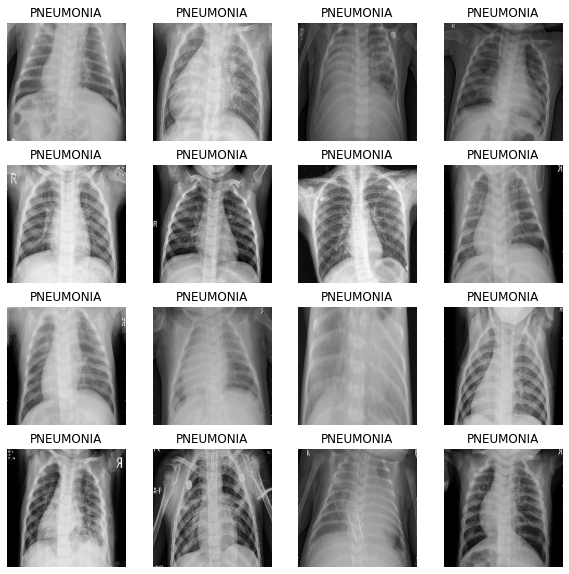

In [17]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(batch_size):
    ax = plt.subplot(4,math.ceil(batch_size/4),n+1)
    plt.imshow(image_batch[n])
    if label_batch[n]:
      plt.title('PNEUMONIA')
    else:
      plt.title('NORMAL')
    plt.axis('off')

image_batch, label_batch = next(iter(train_ds)) 
show_batch(image_batch.numpy(), label_batch.numpy())



##CNN 모델 만들기

In [18]:
def conv_block(filters):
  block = tf.keras.Sequential([
                               tf.keras.layers.SeparableConv2D(filters,3,activation='relu', padding='same'),
                               tf.keras.layers.SeparableConv2D(filters,3,activation='relu', padding='same'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.MaxPool2D()
  ])
  return block

In [19]:
def dense_block(units, dropout_rate):
  block = tf.keras.Sequential([
                               tf.keras.layers.Dense(units, activation='relu'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Dropout(dropout_rate)
  ])

  return block

In [20]:
def build_model():
  model = tf.keras.Sequential([
                               tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1],3)),
                               tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
                               tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
                               tf.keras.layers.MaxPool2D(),

                               conv_block(32),
                               conv_block(64),

                               conv_block(128),
                               tf.keras.layers.Dropout(0.2),

                               conv_block(256),
                               tf.keras.layers.Dropout(0.2),

                               tf.keras.layers.Flatten(),
                               dense_block(512, 0.7),
                               dense_block(128, 0.5),
                               dense_block(64, 0.3),

                               tf.keras.layers.Dense(1,activation='sigmoid')
  ])
  return model

## 데이터 불균형 처리

In [21]:
weight_for_0 = (1/count_normal)*(train_img_count)/2.0
weight_for_1 = (1/count_pneumonia)*(train_img_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for Normal: {:.2f}'.format(weight_for_0))
print('Weight for Pneumonia: {:.2f}'.format(weight_for_1))

Weight for Normal: 1.96
Weight for Pneumonia: 0.67


In [22]:
with tf.device('/GPU:0'):
  model = build_model()

  metrics = [
             'accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')
  ]

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
  

In [24]:
with tf.device('/GPU:0'):
  history = model.fit(
      train_ds,
      steps_per_epoch=train_img_count//batch_size,
      epochs=60,
      validation_data=val_ds,
      validation_steps=val_img_count//batch_size,
      class_weight=class_weight
  )

Epoch 1/60
261/261 [==============================] - 186s 649ms/step - loss: 0.2896 - accuracy: 0.8810 - precision: 0.9601 - recall: 0.8764 - val_loss: 0.8801 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/60
261/261 [==============================] - 76s 294ms/step - loss: 0.2159 - accuracy: 0.9138 - precision: 0.9699 - recall: 0.9124 - val_loss: 1.0499 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/60
261/261 [==============================] - 77s 296ms/step - loss: 0.1904 - accuracy: 0.9298 - precision: 0.9789 - recall: 0.9256 - val_loss: 1.8721 - val_accuracy: 0.5337 - val_precision: 1.0000 - val_recall: 0.3660
Epoch 4/60
261/261 [==============================] - 78s 299ms/step - loss: 0.1742 - accuracy: 0.9344 - precision: 0.9794 - recall: 0.9314 - val_loss: 0.8719 - val_accuracy: 0.7240 - val_precision: 1.0000 - val_recall: 0.6239
Epoch 5/60
261/261 [==============================] - 79s 304ms/step - loss: 0.1703 - accur

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuaracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')


39/39 [==============================] - 143s 4s/step - loss: 1.5158 - accuracy: 0.7564 - precision: 0.7212 - recall: 0.9949
Loss: 1.5157930850982666,
Accuaracy: 0.7564102411270142,
Precision: 0.7211896181106567,
Recall: 0.9948717951774597


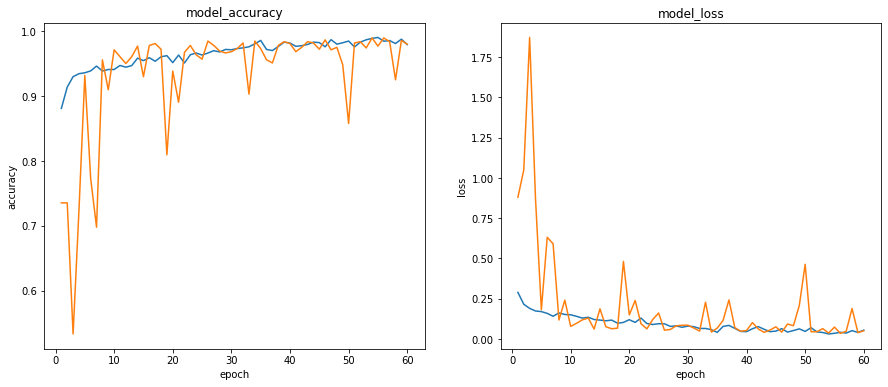

In [26]:
def learning_curve(history, epoch):
  plt.figure(figsize = (15,6))
  epoch_range = np.arange(1, epoch+1)

  plt.subplot(121)
  plt.plot(epoch_range,history.history['accuracy'])
  plt.plot(epoch_range,history.history['val_accuracy'])
  plt.title('model_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')

  plt.subplot(122)
  plt.plot(epoch_range,history.history['loss'])
  plt.plot(epoch_range,history.history['val_loss'])
  plt.title('model_loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')

  plt.show()

learning_curve(history, 60)

##회고
###좌우반전 augment를 넣으니 accuracy가 조금 좋아졌다. 여러 augment에 대해 알아봐야겠다 
###